![Astrofisica Computacional](../logo.PNG)

---
## 02. Physics Informed Neural Networks (PINNs) II


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Abstract

In this notebook we will present the idea of Physics Informed Neural Networks (PINNs) and implement a simple example.

---

## Example 2. Population growth

A logistic model of population growth assumes that a population converges toward an equilibrium.
The population growth can be modeled by the equation

<!-- Equation labels as ordinary links -->
<div id="solveode_population"></div>

$$
\begin{equation} \label{solveode_population} \tag{11}
y'(t) = \alpha y(t)(A - y(t))
\end{equation}
$$

where $y(t)$ is the population density at time $t$, $\alpha > 0$ the growth rate and $A > 0$ is the maximum population number in the environment.
Also, at $t = 0$ the population has the size $y(0) = y_0$, where $y_0$ is some chosen constant.

In this example, a similar network as the one used for the exponential decay (using `autograd`) has been used to solve the equation. However, as the implementation might suffer from some issues, such as numerical instability and high execution time, (this might be more apparent in the examples solving PDEs), using a library like  `TensorFlow` is recommended.
However, we will implement a simple neural network to solve the problem and also the Euler method for comparison.

### Defining the problem

We will model a population $y(t)$ in an environment having carrying capacity $A$ and we will use $\alpha = 2$, $A = 1$, and $y_0 = 1.2$.

### The trial solution

We will use a slightly different trial solution, as the boundary conditions are different compared to the case for exponential decay.

A possible trial solution satisfying the condition $y(0) = y_0$ could be

$$
\begin{equation}
	y_t(x) = y_0 + t \cdot N(t,P)
\label{_auto1} \tag{2}
\end{equation}
$$

with $N(t,P)$ being the output from the neural network with weights and biases for each layer collected in the set $P$.

The analytical solution is

$$
y(t) = \frac{Ay_0}{y_0 + (A - y_0)\exp(-\alpha A t)}
$$

---

## The code for solving the ODE

Note that we will use the library [autograd](https://github.com/HIPS/autograd) for automatic differentiation. A detailed description of this library can be found [here](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/tutorials/tut4.pdf) and [here](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_5_Automatic.html)

/Users/eduard/miniforge3/envs/ashcat/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Initial cost: 0.221805
Final cost: 0.000417932
The max absolute difference between the solutions is: 0.00424909


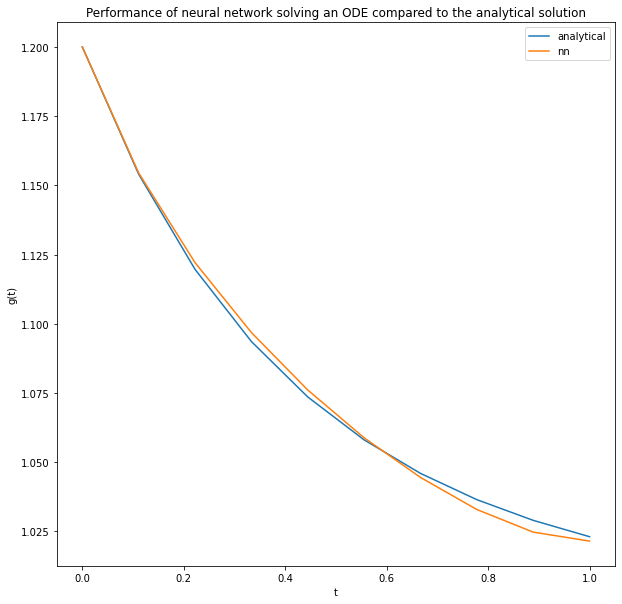

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Function to get the parameters.
# Done such that one can easily change the paramaters after one's liking.
def get_parameters():
    alpha = 2
    A = 1
    g0 = 1.2
    return alpha, A, g0

def deep_neural_network(P, x):
    # N_hidden is the number of hidden layers
    N_hidden = np.size(P) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = P[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = P[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output


def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial_deep,0)(x,P)

    # The right side of the ODE
    func = f(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# The right side of the ODE:
def f(x, g_trial):
    alpha,A, g0 = get_parameters()
    return alpha*g_trial*(A - g_trial)

# The trial solution using the deep neural network:
def g_trial_deep(x, params):
    alpha,A, g0 = get_parameters()
    return g0 + x*deep_neural_network(params,x)

# The analytical solution:
def g_analytic(t):
    alpha,A, g0 = get_parameters()
    return A*g0/(g0 + (A - g0)*np.exp(-alpha*A*t))

def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nt = 10
    T = 1
    t = np.linspace(0,T, Nt)

    ## Set up the initial parameters
    num_hidden_neurons = [100, 50, 25]
    num_iter = 1000
    lmb = 1e-3

    P = solve_ode_deep_neural_network(t, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(t,P)
    g_analytical = g_analytic(t)

    # Find the maximum absolute difference between the solutons:
    diff_ag = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%diff_ag)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(t, g_analytical)
    plt.plot(t, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('t')
    plt.ylabel('g(t)')

    plt.show()

## Using forward Euler to solve the ODE

A straightforward way of solving an ODE numerically, is to use Euler's method.

Euler's method uses Taylor series to approximate the value at a function $f$ at a step $\Delta x$ from $x$:

$$
f(x + \Delta x) \approx f(x) + \Delta x f'(x)
$$

In our case, using Euler's method to approximate the value of $g$ at a step $\Delta t$ from $t$ yields

$$
\begin{aligned}
  g(t + \Delta t) &\approx g(t) + \Delta t g'(t) \\
  &= g(t) + \Delta t \big(\alpha g(t)(A - g(t))\big)
\end{aligned}
$$

along with the condition that $g(0) = g_0$.

Let $t_i = i \cdot \Delta t$ where $\Delta t = \frac{T}{N_t-1}$ where $T$ is the final time our solver must solve for and $N_t$ the number of values for $t \in [0, T]$ for $i = 0, \dots, N_t-1$.

For $i \geq 1$, we have that

$$
\begin{aligned}
t_i &= i\Delta t \\
&= (i - 1)\Delta t + \Delta t \\
&= t_{i-1} + \Delta t
\end{aligned}
$$

Now, if $g_i = g(t_i)$ then

<!-- Equation labels as ordinary links -->
<div id="odenum"></div>

$$
\begin{equation}
  \begin{aligned}
  g_i &= g(t_i) \\
  &= g(t_{i-1} + \Delta t) \\
  &\approx g(t_{i-1}) + \Delta t \big(\alpha g(t_{i-1})(A - g(t_{i-1}))\big) \\
  &= g_{i-1} + \Delta t \big(\alpha g_{i-1}(A - g_{i-1})\big)
  \end{aligned}
\end{equation} \label{odenum} \tag{12}
$$

for $i \geq 1$ and $g_0 = g(t_0) = g(0) = g_0$.

Equation ([12](#odenum)) could be implemented in the following way,
extending the program that uses the network using Autograd:

/Users/eduard/miniforge3/envs/ashcat/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Initial cost: 0.221805
Final cost: 0.000417932
The max absolute difference between the solutions is: 0.00424909
Max absolute difference between Euler method and analytical: 0.011225
Max absolute difference between deep neural network and analytical: 0.00424909


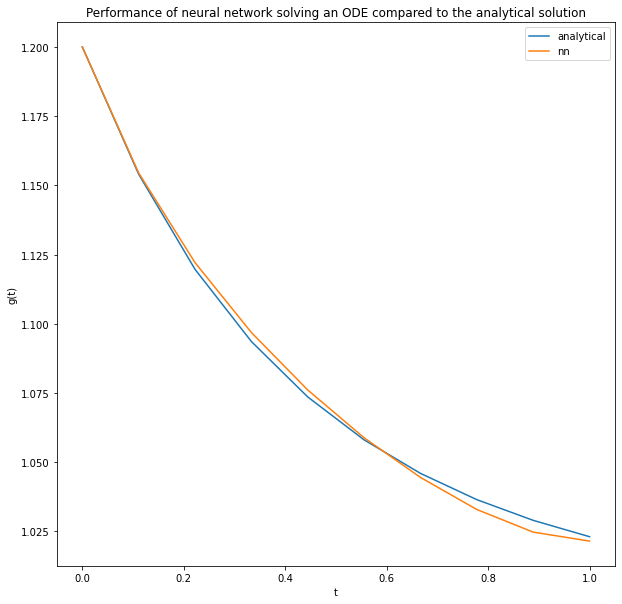

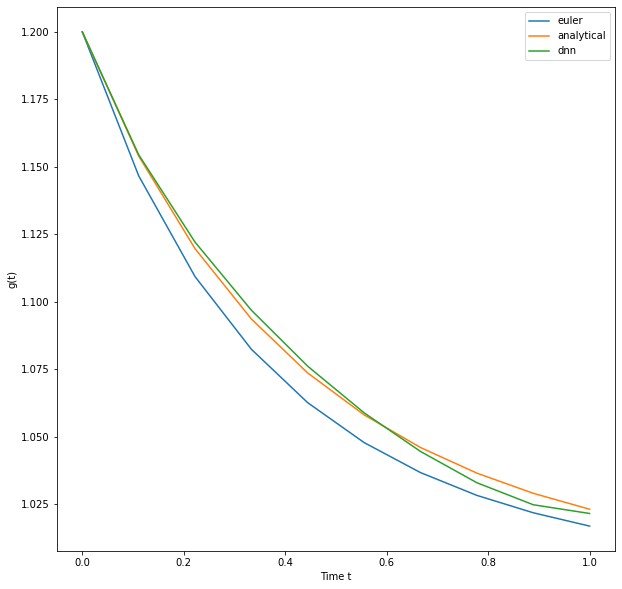

In [2]:
# Assume that all function definitions from the example program using Autograd
# are located here.

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nt = 10
    T = 1
    t = np.linspace(0,T, Nt)

    ## Set up the initial parameters
    num_hidden_neurons = [100,50,25]
    num_iter = 1000
    lmb = 1e-3

    P = solve_ode_deep_neural_network(t, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(t,P)
    g_analytical = g_analytic(t)

    # Find the maximum absolute difference between the solutons:
    diff_ag = np.max(np.abs(g_dnn_ag - g_analytical))
    print("The max absolute difference between the solutions is: %g"%diff_ag)

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(t, g_analytical)
    plt.plot(t, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('t')
    plt.ylabel('g(t)')

    ## Find an approximation to the funtion using forward Euler

    alpha, A, g0 = get_parameters()
    dt = T/(Nt - 1)

    # Perform forward Euler to solve the ODE
    g_euler = np.zeros(Nt)
    g_euler[0] = g0

    for i in range(1,Nt):
        g_euler[i] = g_euler[i-1] + dt*(alpha*g_euler[i-1]*(A - g_euler[i-1]))

    # Print the errors done by each method
    diff1 = np.max(np.abs(g_euler - g_analytical))
    diff2 = np.max(np.abs(g_dnn_ag[0,:] - g_analytical))

    print('Max absolute difference between Euler method and analytical: %g'%diff1)
    print('Max absolute difference between deep neural network and analytical: %g'%diff2)

    # Plot results
    plt.figure(figsize=(10,10))

    plt.plot(t,g_euler)
    plt.plot(t,g_analytical)
    plt.plot(t,g_dnn_ag[0,:])

    plt.legend(['euler','analytical','dnn'])
    plt.xlabel('Time t')
    plt.ylabel('g(t)')

    plt.show()